In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import carna.py as cpy
import scipy.ndimage as ndi
import skimage.io

In [3]:
print(f'Carna {cpy.version} (CarnaPy {cpy.py_version})')

Carna 3.0.2 (CarnaPy 0.0.1)


# Example data

**3D microscopy data used for examples:** [*Kalinin, A.A., Allyn-Feuer, A., Ade, A., Fon, G.V., Meixner, W., Dilworth, D., Jeffrey, R., Higgins, G.A., Zheng, G., Creekmore, A., et al., 2018. 3D cell nuclear morphology: Microscopy imaging dataset and voxel-based morphometry classification results, in: Proceedings of the Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), IEEE. pp. 2272–2280.*](http://www.socr.umich.edu/projects/3d-cell-morphometry/data.html)

Image from a 3D stack, annotated with some example markers:

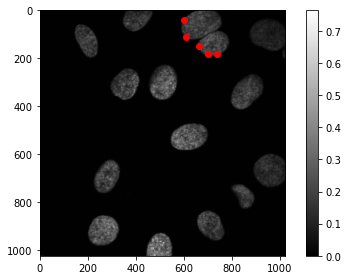

In [4]:
data = skimage.io.imread('../../08_06_NormFibro_Fibrillarin_of_07_31_Slide2_num2_c0_g006.tif').T
data = data / data.max()

markers = array([
    [40, 600, 15],
    [110, 610, 15],
    [150, 665, 15],
    [180, 700, 15],
    [180, 740, 15],
])

imshow(data[:,:, 15], 'gray')
colorbar()
scatter(*markers[:,:-1][:,::-1].T, c='r')
tight_layout()

The z-spacing is unknown, so we will just assume that z-resolution is 4 times lower than x-/y-resolution:

In [5]:
spacing = (1, 1, 4)

Transform marker positions into world coordinates:

In [6]:
markers_world = (markers - subtract(data.shape, 1) / 2) * spacing

# Direct volume rendering

**Example 1.** Use `dvr` to issue a direct volume rendering:

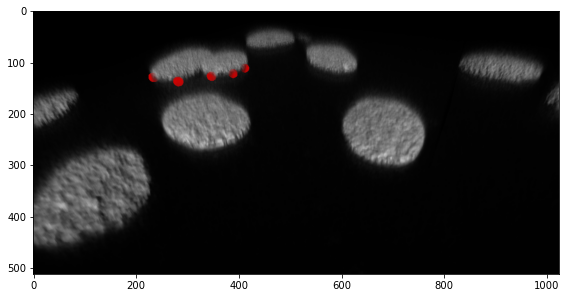

In [7]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing, normals=True) ## declaration of the volume data
    rc.dvr(translucency=2, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

Remember to pass `normals=True` to the declaration of the volume data via `volume` to issue a computation of the normal vectors, which is required to perform lighting.

**Example 2.** You can also use a more sophisticated color map, like $[0,0.2) \mapsto$ teal and $[0.4,1] \mapsto$ yellow:

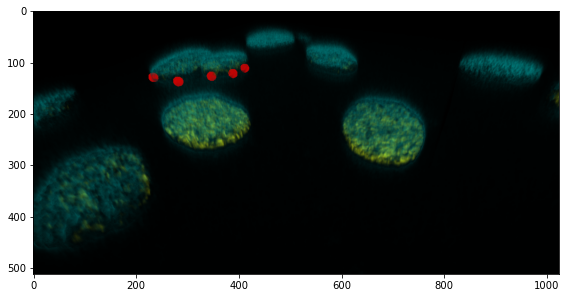

In [8]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing, normals=True) ## declaration of the volume data
    rc.dvr(color_map=[(0, 0.2, (0, 1, 1, 0), (0, 1, 1, 0.2)), (0.4, 1.0, (1, 1, 0, 0), (1, 1, 0, 1))], translucency=2, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 3.** Direct volume rendering can also be performed without lighting:

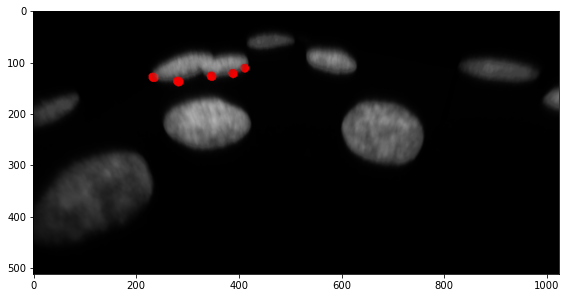

In [9]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing)
    rc.dvr(translucency=20, sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

Omitting `normals=True` if lighting is not required speeds up the `volume` command but produces less realistic renderings.

# Maximum intensity projection

**Example 4.** Use `rc.mip` to specify a maximum instensity projection:

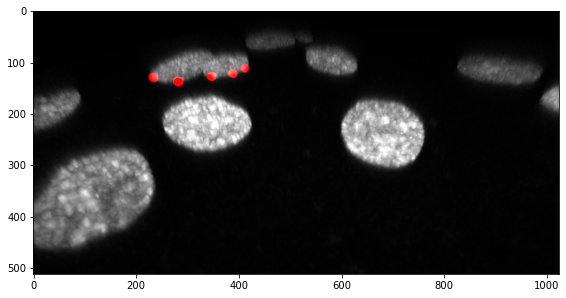

In [10]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing)
    rc.mip(sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 5.** Use the `layers` parameter of `rc.mip` to specify the color map and/or multiple layers.

In this example, intensities $[0,0.2)$ are mapped linearly to blue, whereas intensities $[0.4, 1]$ are mapped linearly to yellow:

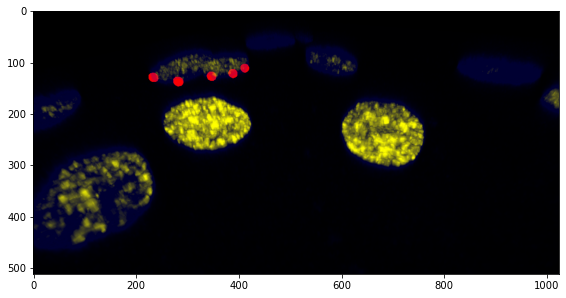

In [11]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing)
    rc.mip(layers=[(0, 0.2, (0, 0, 1, 0.2)), (0.4, 1, (1, 1, 0, 1))], sample_rate=500)
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

# Cutting plane rendering

**Example 6.** Use `rc.plane` to define cutting planes:

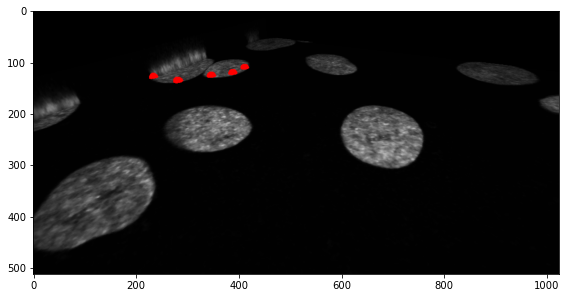

In [12]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing)
    rc.plane((0,0,1), markers_world[0]) ## cutting plane through the first marker with normal vector along z-axis
    rc.plane((1,0,0), markers_world[0]) ## cutting plane through the first marker with normal vector along x-axis
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

**Example 7.** Add `rc.occluded()` to visualize visually occluded geometry: (note that the markers are half-translucent)

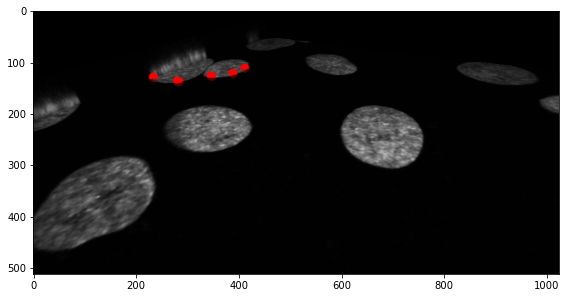

In [13]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing)
    rc.plane((0,0,1), markers_world[0]) ## cutting plane through the first marker with normal vector along z-axis
    rc.plane((1,0,0), markers_world[0]) ## cutting plane through the first marker with normal vector along x-axis
    marker_mesh = rc.ball(radius=10)
    marker_material = rc.material(color=(1,0,0,1))
    rc.meshes(marker_mesh, marker_material, markers_world)
    rc.occluded()
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()

# Combining diffewrent visualization techniques

**Example 8.** This example shows the combination of maximum intensity projection and cutting planes: (the markers are left out for clarity)

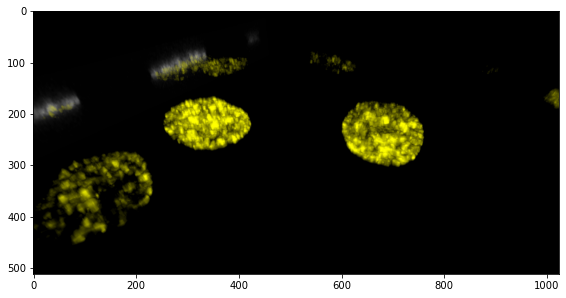

In [14]:
with cpy.SingleFrameContext((512, 1024), fov=45, near=1, far=1000) as rc:
    rc.volume(data, spacing=spacing)
    rc.plane((1,0,0), markers_world[0]) ## cutting plane through the first marker with normal vector along x-axis
    rc.mip(layers=[(0.4, 1, (1, 1, 0, 1))], sample_rate=500)
    rc.camera.rotate((1,1,0), 35, 'deg').rotate((1,0,0), 15, 'deg').translate(-50, 0, 250).rotate((0,0,1), 35, 'deg')
    
figure(figsize=(8,6))
imshow(rc.result)
tight_layout()